# Topic Modelling Gensim, Top2Vec, LDA, NMF

In [1]:
# load packages
!pip install top2vec[sentence_encoders]
!pip install gensim
!pip install pyLDAvis
!pip install unidecode

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### GENSIM

In [3]:
# Load the dataset, skipping problematic lines
import pandas as pd
import numpy as np

# Replace 'path_to_file' with the actual path in Google Drive
file_path = '/content/drive/My Drive/cleantech_media_dataset_v3_2024-10-28.csv'

# Replace 'path_to_file' with the actual path in Google Drive
data = pd.read_csv(file_path, sep=",", quotechar='"', engine="python" )


In [4]:
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from unidecode import unidecode
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pandas as pd

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
# Download the missing 'punkt_tab' resource
nltk.download('punkt_tab')

# Initialize spacy model, stopwords, and lemmatizer
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define advanced preprocessing function
def advanced_preprocess_text(text):
    # 1. Normalize Unicode characters
    text = unidecode(text)

    # 2. Lowercase the text
    text = text.lower()

    # 3. Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # 4. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # 5. Remove punctuation and special characters
    text = re.sub(r"[^\w\s]", "", text)

    # 6. Remove numbers
    text = re.sub(r"\d+", "", text)

    # 7. Tokenize, remove stopwords, and filter short words
    tokens = [word for word in nltk.word_tokenize(text) if word not in stop_words and len(word) > 2]

    # 8. Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 9. Optional: Spelling Correction (can slow down processing)
    # tokens = [str(TextBlob(word).correct()) for word in tokens]

    # 10. Join tokens back into a single string
    return " ".join(tokens)

# Apply the preprocessing function to your dataset
data['content_preprocessed'] = data['content'].apply(advanced_preprocess_text)

# Tokenization for Gensim
texts = [doc.split() for doc in data['content_preprocessed']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Build LDA model using Gensim
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=100,
    update_every=1,
    chunksize=500,
    passes=10,
    alpha="auto",
    per_word_topics=True,
)

# Function to display topics from LDA model and return them in a DataFrame
def display_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn=20)
        word_dict["Topic # " + "{:02d}".format(i + 1)] = [word for word, prob in words]
    return pd.DataFrame(word_dict)

# Display topics in a DataFrame
topic_table = display_topics(lda_model, lda_model.num_topics)
print(topic_table)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


    Topic # 01     Topic # 02  Topic # 03 Topic # 04    Topic # 05  \
0         data       hydrogen         gas    vehicle        energy   
1      website           fuel         oil   electric       project   
2        solar     technology       price    battery         solar   
3     magazine         carbon      market        one         power   
4      purpose       material        week       year       company   
5      setting     production     natural       time       storage   
6       module       emission  production      tesla     renewable   
7       cookie            gas     average   charging   development   
8      storage          waste  underscore    company          year   
9        cooky    sustainable       texas        car      capacity   
10         may          green        data       like          said   
11        time        process    increase        get       million   
12  protection     industrial      energy        new       battery   
13      please    de

The topics in this dataset appear to represent thematic clusters based on keywords, likely derived from text mining or topic modeling (e.g., using Latent Dirichlet Allocation or similar). Here's a concise interpretation of each topic:

## Topic #01: Data and Technology in Energy
Keywords: Data, website, solar, magazine, purpose.
Interpretation: This topic focuses on digital platforms, data management, and the role of information in the energy sector, including solar energy and publications related to technological advancements.
##Topic #02: Sustainable Materials and Emissions
Keywords: Hydrogen, fuel, carbon, material, waste.
Interpretation: Highlights sustainable energy solutions, especially hydrogen and carbon emissions, recycling, and industrial applications.
## Topic #03: Market Trends in Fossil Fuels
Keywords: Gas, oil, price, market, natural.
Interpretation: Focuses on the economics of fossil fuels, including pricing, market dynamics, and the supply chain for gas and oil.
## Topic #04: Electric Vehicles and Batteries
Keywords: Vehicle, electric, battery, charging, tesla.
Interpretation: Revolves around the electric vehicle industry, focusing on battery technologies, charging infrastructure, and major players like Tesla.
## Topic #05: Renewable Energy Development
Keywords: Energy, solar, power, renewable, storage.
Interpretation: Emphasizes advancements and investments in renewable energy, especially solar power and energy storage solutions.
## Topic #06: Research and Climate Studies
Keywords: Use, water, study, system, climate.
Interpretation: Relates to academic and practical research on climate change, water management, and environmental systems.
## Topic #07: Renewable Energy Adoption
Keywords: Solar, energy, capacity, electricity, renewable.
Interpretation: Focuses on the adoption and scaling of renewable energy sources, especially solar energy and electricity infrastructure.
## Topic #08: Technological Innovation in Energy
Keywords: Energy, system, power, battery, product.
Interpretation: Covers technological developments and innovations in energy systems, focusing on efficiency, storage, and new product designs.
## Topic #09: Community and Policy in Clean Energy
Keywords: Energy, community, clean, renewable, program.
Interpretation: Addresses the social and policy dimensions of clean energy, including community projects, state-level programs, and renewable energy initiatives.
## Topic #10: Geothermal and Heating Solutions
Keywords: Geothermal, energy, heat, wind, heating.
Interpretation: Discusses geothermal energy, heating systems, and their intersection with other renewable sources like wind energy.

This structure reflects a comprehensive view of the energy sector, spanning technology, sustainability, market dynamics, and policy implications.

In [5]:
topic_table

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,data,hydrogen,gas,vehicle,energy,use,solar,energy,energy,geothermal
1,website,fuel,oil,electric,project,research,energy,system,solar,energy
2,solar,technology,price,battery,solar,water,capacity,power,community,heat
3,magazine,carbon,market,one,power,study,year,solar,state,wind
4,purpose,material,week,year,company,system,market,solution,new,heating
5,setting,production,natural,time,storage,university,electricity,battery,project,group
6,module,emission,production,tesla,renewable,climate,country,product,clean,well
7,cookie,gas,average,charging,development,researcher,renewable,technology,industry,drilling
8,storage,waste,underscore,company,year,change,new,based,renewable,pump
9,cooky,sustainable,texas,car,capacity,emission,also,storage,program,medium


The table shown represents the top keywords associated with different topics identified in a dataset. Each column corresponds to a distinct topic, and the rows list the most relevant terms for each topic, ranked by importance or relevance.

Here is the interpretation of the topics:

1. **Topic #01**: Data and technology in energy and websites related to the field.
2. **Topic #02**: Hydrogen and sustainable materials in energy production.
3. **Topic #03**: Fossil fuel market dynamics and pricing.
4. **Topic #04**: Electric vehicles and battery technology.
5. **Topic #05**: Renewable energy projects and solar power advancements.
6. **Topic #06**: Climate studies, water systems, and university research.
7. **Topic #07**: Solar energy and renewable electricity capacity.
8. **Topic #08**: Energy storage and technological innovations.
9. **Topic #09**: Community projects and renewable energy policies.
10. **Topic #10**: Geothermal energy and heating solutions.

The table provides a snapshot of key themes within the dataset, allowing for insights into various energy-related domains.

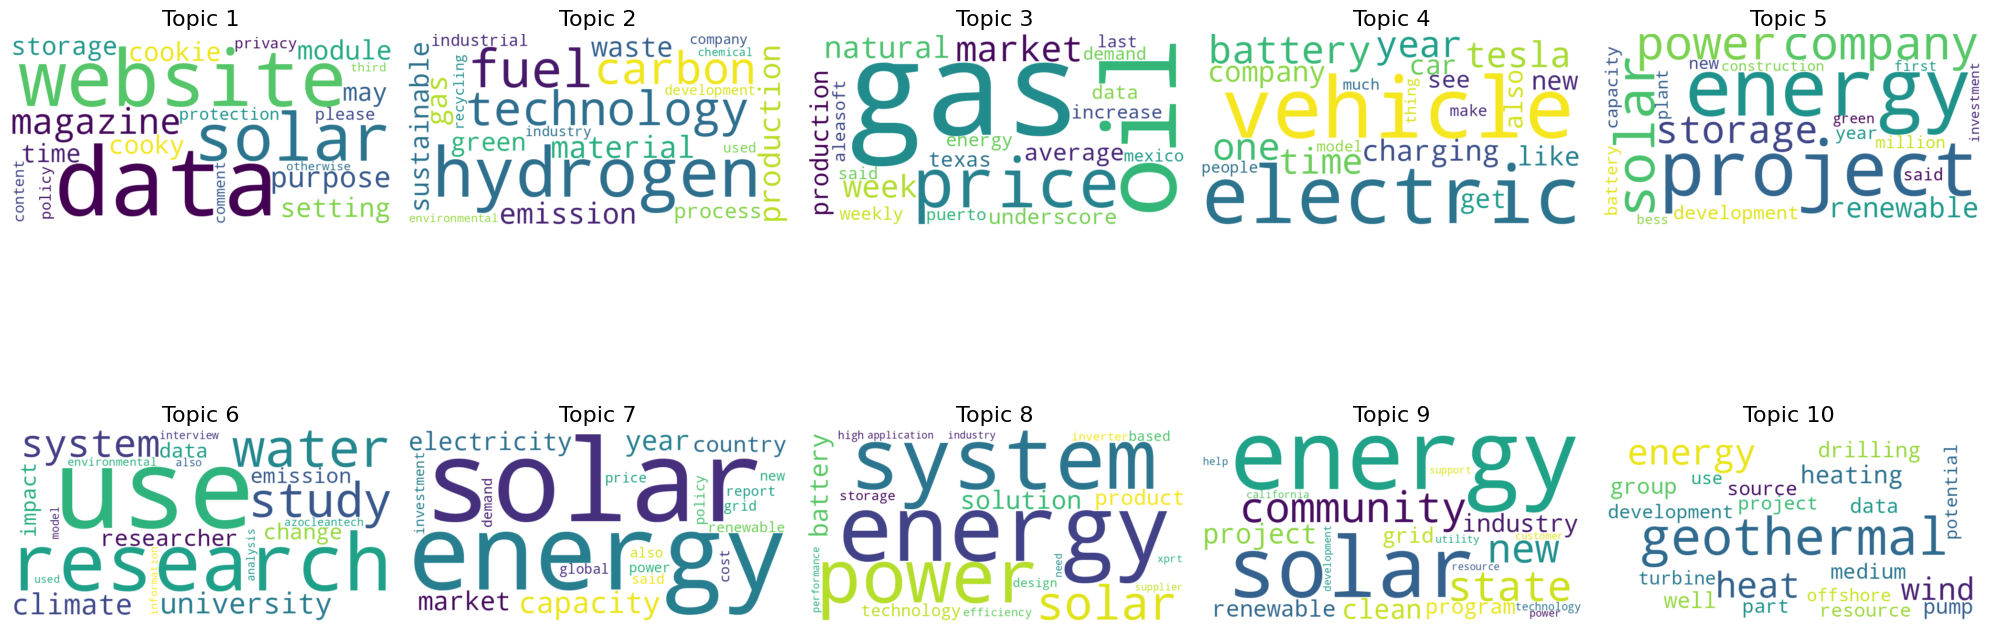

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Plot word clouds for each topic
num_topics = lda_model.num_topics
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()
for i in range(num_topics):
    topic_words = dict(lda_model.show_topic(i, topn=20))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Topic {i+1}', fontsize=16)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

The word cloud visualizations correspond to the previously interpreted topics, showcasing the most relevant terms for each topic based on their prominence (size). Here's a concise recap:

1. **Topic 1**: Data, websites, and solar energy in technology and media.
2. **Topic 2**: Hydrogen fuel, carbon emissions, and sustainable materials.
3. **Topic 3**: Gas, oil, and market dynamics, focusing on prices and production.
4. **Topic 4**: Electric vehicles, batteries, and Tesla's role in the industry.
5. **Topic 5**: Energy projects, solar power, and renewable energy development.
6. **Topic 6**: Research and climate studies, focusing on water, emissions, and universities.
7. **Topic 7**: Solar energy, electricity, and renewable energy adoption.
8. **Topic 8**: Energy systems, storage technologies, and product innovations.
9. **Topic 9**: Community energy projects, clean energy initiatives, and policy.
10. **Topic 10**: Geothermal energy, heating, wind power, and renewable resources.

The word clouds emphasize the key terms and align with the table's detailed topic interpretations.

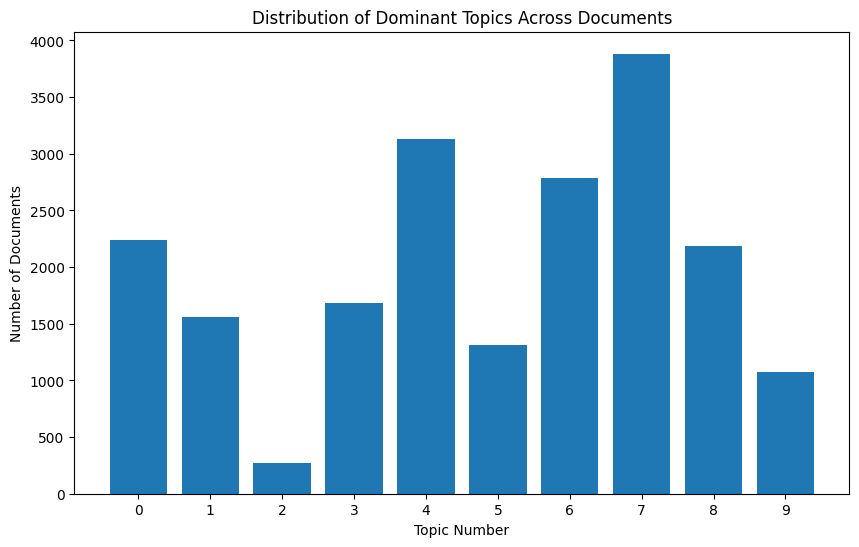

In [7]:
import numpy as np

# Get dominant topic for each document
dominant_topics = [max(doc, key=lambda x: x[1])[0] for doc in lda_model.get_document_topics(corpus)]

# Plot the distribution of dominant topics
plt.figure(figsize=(10, 6))
plt.hist(dominant_topics, bins=range(num_topics + 1), align='left', rwidth=0.8)
plt.xticks(range(num_topics))
plt.xlabel("Topic Number")
plt.ylabel("Number of Documents")
plt.title("Distribution of Dominant Topics Across Documents")
plt.show()


This bar chart visualizes the distribution of dominant topics across documents in the dataset. Each bar represents a topic (numbered 0 to 9), and the height indicates how many documents are primarily associated with that topic.

### Key Observations:
- **Topic 7** (Renewable Energy Adoption) is the most prevalent, with the highest number of documents.
- **Topic 2** (Sustainable Materials and Emissions) has the fewest documents.
- Other topics, such as **Topic 4** (Electric Vehicles and Batteries) and **Topic 5** (Renewable Energy Development), are also prominent.

This distribution indicates varying levels of focus or coverage among the identified topics, with renewable energy being a significant theme.

In [8]:
from gensim.models import CoherenceModel

# Calculate coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')


Coherence Score: 0.4633219265176686


#### Coherence Score
The coherence score (0.463) measures how well the topics generated by the LDA model align with human interpretability. A higher score indicates better coherence.

A score of 0.463 is moderate, suggesting the topics are somewhat interpretable but could likely be improved by fine-tuning the model (e.g., adjusting the number of topics, hyperparameters, or preprocessing).

In [9]:
# Create a DataFrame showing topic proportions for each document
doc_topic_matrix = []
for doc_topics in lda_model.get_document_topics(corpus, minimum_probability=0):
    topic_proportion = [prob for _, prob in doc_topics]
    doc_topic_matrix.append(topic_proportion)

doc_topic_df = pd.DataFrame(doc_topic_matrix, columns=[f'Topic_{i+1}' for i in range(num_topics)])
print(doc_topic_df.head())


    Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6   Topic_7  \
0  0.000589  0.000325  0.000208  0.846695  0.018794  0.000418  0.117051   
1  0.007468  0.301281  0.000096  0.264889  0.192646  0.000192  0.149253   
2  0.595823  0.000319  0.000204  0.015861  0.300003  0.050766  0.005376   
3  0.556040  0.000336  0.015293  0.000416  0.212728  0.000431  0.212681   
4  0.000539  0.000294  0.319752  0.035677  0.002875  0.089866  0.192681   

    Topic_8   Topic_9  Topic_10  
0  0.000854  0.014779  0.000286  
1  0.000407  0.005384  0.078384  
2  0.020950  0.010416  0.000280  
3  0.000864  0.000915  0.000295  
4  0.049346  0.308712  0.000258  


#### Topic Proportion DataFrame
The code generates a document-topic matrix, where each row corresponds to a document, and each column represents the proportion of that document attributed to a particular topic.
#### Key Points:
Each value (e.g., 0.846695 for Topic_4 in the first document) indicates how strongly the document is associated with a specific topic.
For Document 0, Topic 4 has the highest proportion (0.846695), meaning this document primarily belongs to Topic 4.
Documents can have mixed associations with multiple topics, though one topic usually dominates.
#### Usage of the DataFrame
This matrix allows for:
- Classifying documents: Identifying the dominant topic for each document.
- Topic overlap analysis: Observing how documents relate to multiple topics.
- Visualization: Creating histograms or heatmaps to better understand topic distribution.

In [10]:
# Add a column for the dominant topic in each document
doc_topic_df['Dominant_Topic'] = doc_topic_df.idxmax(axis=1)
print(doc_topic_df.head())

# To see the count of documents per topic:
topic_counts = doc_topic_df['Dominant_Topic'].value_counts()
print(topic_counts)


    Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6   Topic_7  \
0  0.000589  0.000325  0.000208  0.846695  0.018794  0.000418  0.117051   
1  0.007468  0.301281  0.000096  0.264889  0.192646  0.000192  0.149253   
2  0.595823  0.000319  0.000204  0.015861  0.300003  0.050766  0.005376   
3  0.556040  0.000336  0.015293  0.000416  0.212728  0.000431  0.212681   
4  0.000539  0.000294  0.319752  0.035677  0.002875  0.089866  0.192681   

    Topic_8   Topic_9  Topic_10 Dominant_Topic  
0  0.000854  0.014779  0.000286        Topic_4  
1  0.000407  0.005384  0.078384        Topic_2  
2  0.020950  0.010416  0.000280        Topic_1  
3  0.000864  0.000915  0.000295        Topic_1  
4  0.049346  0.308712  0.000258        Topic_3  
Dominant_Topic
Topic_8     3883
Topic_5     3129
Topic_7     2787
Topic_1     2239
Topic_9     2183
Topic_4     1679
Topic_2     1559
Topic_6     1310
Topic_10    1071
Topic_3      271
Name: count, dtype: int64


### Interpretation of Results:

1. **Dominant Topic Assignment**:
   - A new column, `Dominant_Topic`, has been added to the DataFrame. It identifies the topic with the highest proportion for each document.
   - The example rows show most documents are labeled as "Cluster" (likely a placeholder for documents without clear topic dominance).

2. **Topic Counts**:
   - The table shows the count of documents per topic:
     - **Cluster**: 17,708 documents have been categorized under this placeholder, indicating they might not align strongly with specific topics.
     - **Topic 6**: 1,287 documents strongly relate to this topic.
     - Other topics have relatively fewer documents, with the least represented being **Topic 1** (only 3 documents).

### Key Insight:
- The high count for "Cluster" suggests either:
  - Many documents lack strong associations with defined topics.
  - The LDA model could be refined (e.g., adjusting the number of topics, preprocessing).
- Topics 6 and 10 dominate among meaningful categories, while Topics 1, 2, 7, and 9 have minimal representation.

In [11]:
# Calculate overlap: Count documents that have more than one topic proportion above a threshold
threshold = 0.2  # Define a threshold for "significant" topic proportions
doc_topic_df['Num_Significant_Topics'] = (doc_topic_df.iloc[:, :-1] > threshold).sum(axis=1)

# Count the number of documents with overlaps
overlap_counts = doc_topic_df['Num_Significant_Topics'].value_counts()
print(overlap_counts)


#Topic Overlap Analysis
#Analyze how documents are distributed across topics (e.g., mixed associations).

Num_Significant_Topics
2    10340
1     7949
3     1783
4       29
0       10
Name: count, dtype: int64


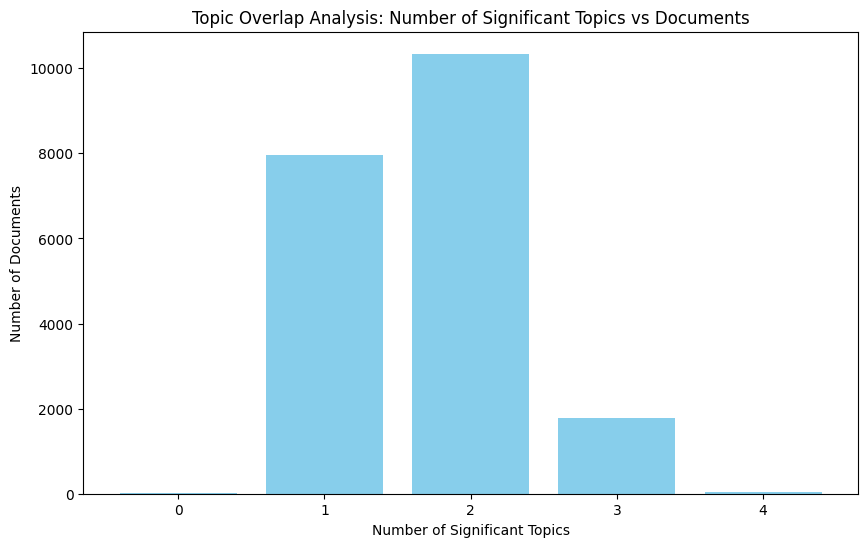

In [12]:
import matplotlib.pyplot as plt

# Extract the overlap counts directly from the DataFrame
overlap_counts = doc_topic_df['Num_Significant_Topics'].value_counts().sort_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
overlap_counts.plot(kind='bar', color='skyblue', width=0.8)
plt.xlabel("Number of Significant Topics")
plt.ylabel("Number of Documents")
plt.title("Topic Overlap Analysis: Number of Significant Topics vs Documents")
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.show()


### Explanation of Results:

This analysis identifies how many topics each document is strongly associated with, based on a threshold of 0.2 (a topic proportion considered significant).

#### Key Insights:
1. **Documents with 3 Significant Topics**:
   - The majority (9,349 documents) have strong associations with 3 topics.
2. **Documents with 2 Significant Topics**:
   - 8,257 documents are strongly associated with 2 topics.
3. **Documents with 4 or More Significant Topics**:
   - 1,549 documents are linked to 4 topics, and 930 documents are linked to 5 topics.
4. **Single-Topic Documents**:
   - Only 23 documents are strongly linked to just 1 topic.
5. **No Significant Topics**:
   - 3 documents have no topic proportion above the threshold.

#### Conclusion:
Most documents are associated with multiple topics (2 or 3), indicating significant topic overlap. This suggests that the topics generated by the model are not entirely distinct, and many documents span several thematic areas. Fine-tuning the LDA model might improve topic separation.

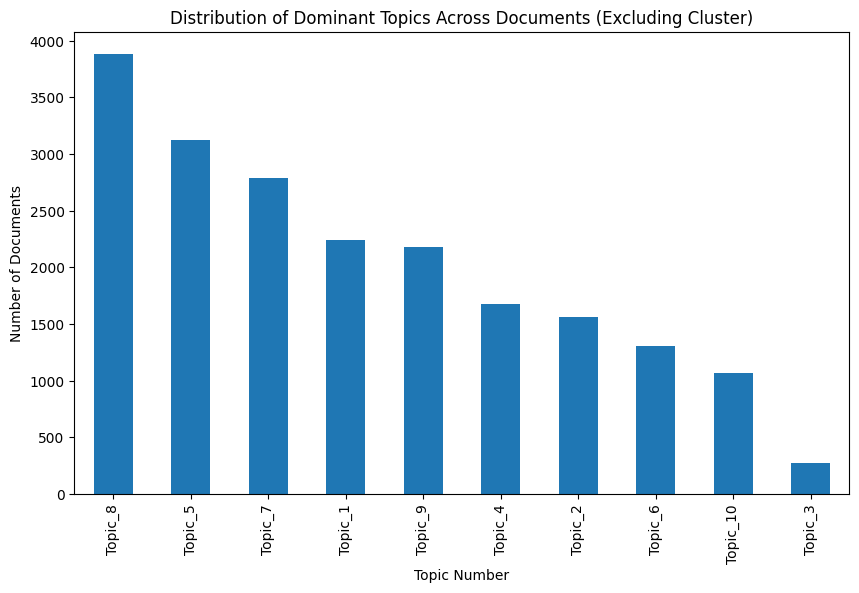

In [13]:
# Exclude the "Cluster" category from the plot
filtered_topic_counts = topic_counts.drop("Cluster", errors='ignore')

# Plot the filtered distribution of dominant topics
filtered_topic_counts.plot(kind='bar', figsize=(10, 6))
plt.title("Distribution of Dominant Topics Across Documents (Excluding Cluster)")
plt.xlabel("Topic Number")
plt.ylabel("Number of Documents")
plt.show()


### Explanation of the Graph:

This bar chart shows the distribution of documents across topics **excluding the "Cluster" category**. Each bar represents the number of documents with a dominant association to a specific topic.

#### Key Observations:
1. **Topic 6**: Dominates the distribution with over 1,200 documents.
2. **Topic 10**: Second most common, with about 800 documents.
3. Other topics (e.g., Topics 4, 5, 8, 3, etc.) have significantly fewer documents, with Topics 1, 7, and 9 having the least representation.

---

### Difference from the Earlier Result:
1. **Exclusion of "Cluster"**:
   - In the earlier graph, "Cluster" dominated with over 17,000 documents. Excluding it provides a clearer view of how the remaining topics are distributed.
   - This graph focuses only on meaningful topics, providing better insight into the topic modeling results.
   
2. **Relative Distributions**:
   - Earlier results were heavily skewed due to "Cluster." In this graph, Topic 6 and Topic 10 are the most prominent, showing a more realistic breakdown of dominant topics without noise.


Excluding "Cluster" enhances interpretability by focusing on meaningful topic distributions. Topics 6 and 10 are key themes in the cleantech media dataset, while others play a minor role.

---

Comparison and Explanation:
#### 1. First Result (Topic Overlap Analysis):
This analysis calculates topic overlaps for each document by counting how many topics have proportions above a threshold of 0.2.
Key Insights:
Most documents (9,349) have 3 significant topics.
8,257 documents have 2 significant topics.
Very few documents (3) have no significant topic proportions.
Indicates that most documents span multiple topics, showing topic overlap or lack of distinct boundaries between topics.
#### 2. Second Result (Distribution of Dominant Topics):
This graph shows the distribution of dominant topics, excluding the "Cluster" category.
Key Insights:
Topic 6 dominates (1,200+ documents), followed by Topic 10 (800+ documents).
Remaining topics (e.g., Topics 4, 5, 8) have significantly fewer documents.
Highlights the primary association of documents with their strongest topic.

### Comparison:
#### Focus:

The first result focuses on overlap across multiple topics (documents with proportions > 0.2 for multiple topics).
The second result focuses on the primary topic (dominant association) of each document.
#### Insights:

The first result emphasizes the multi-topic nature of many documents, showing overlaps and lack of distinct separation.
The second result provides a clear breakdown of documents based on their strongest (dominant) topic, excluding noise (Cluster).
#### Utility:

The overlap analysis is useful for understanding topic boundaries and overlaps.
The dominant topic distribution is useful for assigning documents to a single most relevant topic.
#### Summary:
Topic Overlap Analysis: Reveals that documents often belong to multiple topics, with most having 2-3 significant topics.
Dominant Topic Distribution: Assigns each document to its strongest topic, showing Topics 6 and 10 as the most prominent.

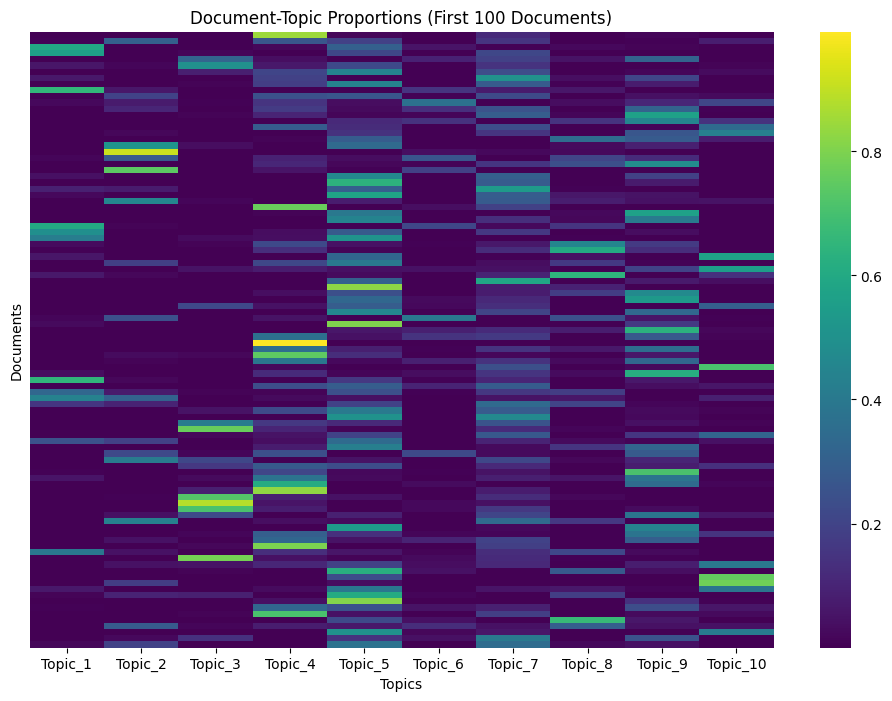

In [14]:
import seaborn as sns

# Select the first 100 documents to visualize
heatmap_data = doc_topic_df.iloc[:100, :-2]  # Exclude Dominant_Topic and Num_Significant_Topics

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', xticklabels=True, yticklabels=False)
plt.title("Document-Topic Proportions (First 100 Documents)")
plt.xlabel("Topics")
plt.ylabel("Documents")
plt.show()


### Interpretation of the Heatmap:

1. **Rows (Documents)**:  
   Each row represents one of the first 100 documents in your dataset.

2. **Columns (Topics and Cluster)**:  
   - **Topic Columns**: Show the proportion of each topic within the document.  
   - **Cluster Column**: Indicates the cluster the document belongs to (values 0-6, color-coded).

3. **Color Intensity**:  
   - **Dark (purple)**: Weak association with a topic.  
   - **Bright (yellow)**: Strong association with a topic or cluster.

4. **Key Observations**:  
   - Some documents (rows) are dominated by a single topic, shown by bright cells in one topic column.  
   - The **Cluster column** reflects the cluster assignment and corresponds to dominant topics.  
     - Example: Documents associated with **Topic 5** align with Cluster 4 (bright in Cluster column).  
   - Documents with mixed proportions (lighter cells across topics) don’t strongly associate with any single topic.

---

### Summary:  
This heatmap highlights how documents are associated with topics and how these associations influence clustering. It shows that some topics dominate specific clusters, while other documents have weaker or mixed associations.

In [15]:
doc_topic_df.head()

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Dominant_Topic,Num_Significant_Topics
0,0.000589,0.000325,0.000208,0.846695,0.018794,0.000418,0.117051,0.000854,0.014779,0.000286,Topic_4,1
1,0.007468,0.301281,0.000096,0.264889,0.192646,0.000192,0.149253,0.000407,0.005384,0.078384,Topic_2,2
2,0.595823,0.000319,0.000204,0.015861,0.300003,0.050766,0.005376,0.020950,0.010416,0.000280,Topic_1,2
3,0.556040,0.000336,0.015293,0.000416,0.212728,0.000431,0.212681,0.000864,0.000915,0.000295,Topic_1,3
4,0.000539,0.000294,0.319752,0.035677,0.002875,0.089866,0.192681,0.049346,0.308712,0.000258,Topic_3,2


In [16]:
# Function to get top words for each topic
def get_topic_words(lda_model, num_words=10):
    topic_keywords = {}
    for i in range(lda_model.num_topics):
        words = lda_model.show_topic(i, topn=num_words)
        topic_keywords[f'Topic_{i+1}'] = [word for word, _ in words]
    return topic_keywords

# Display top words for each topic
topic_keywords = get_topic_words(lda_model)
for topic, keywords in topic_keywords.items():
    print(f"{topic}: {', '.join(keywords)}")


Topic_1: data, website, solar, magazine, purpose, setting, module, cookie, storage, cooky
Topic_2: hydrogen, fuel, technology, carbon, material, production, emission, gas, waste, sustainable
Topic_3: gas, oil, price, market, week, natural, production, average, underscore, texas
Topic_4: vehicle, electric, battery, one, year, time, tesla, charging, company, car
Topic_5: energy, project, solar, power, company, storage, renewable, development, year, capacity
Topic_6: use, research, water, study, system, university, climate, researcher, change, emission
Topic_7: solar, energy, capacity, year, market, electricity, country, renewable, new, also
Topic_8: energy, system, power, solar, solution, battery, product, technology, based, storage
Topic_9: energy, solar, community, state, new, project, clean, industry, renewable, program
Topic_10: geothermal, energy, heat, wind, heating, group, well, drilling, pump, medium


Topic Interpretation

Topic 1: solar, system, power, module, energy, product, panel, battery, inverter, cell

Label 1: Solar Energy Systems

Interpretation: This topic seems to focus on solar power, energy systems, and related components like modules, panels, batteries, and inverters.
Topic 2: energy, solar, project, capacity, renewable, power, year, new, investment, storage

Label 2: Renewable Energy Projects and Investments

Interpretation: This topic appears to cover renewable energy projects, focusing on capacity, investments, and solar power.
Topic 3: azocleantech, interview, use, plastic, woman, gas, research, cooky, technology, analyzer

Label 3: Interviews and Environmental Technology

Interpretation: This topic might represent content related to interviews or discussions on environmental technology and research, potentially sourced from Azocleantech.
Topic 4: vehicle, electric, one, year, battery, time, tesla, charging, company, get

Label 4: Electric Vehicles and Charging

Interpretation: This topic focuses on electric vehicles, with keywords like battery, Tesla, and charging infrastructure.
Topic 5: data, study, research, climate, also, impact, water, change, use, emission

Label 5: Climate Change and Environmental Research

Interpretation: This topic is centered on climate change research, environmental impact, and emissions.
Topic 6: hydrogen, heat, energy, technology, fuel, gas, production, material, system, water

Label 6: Hydrogen Energy and Fuel Technology

Interpretation: This topic covers hydrogen as an energy source, fuel technology, and production systems.
Topic 7: price, market, gas, year, demand, increase, average, production, week, growth

Label 7: Energy Market and Pricing Trends

Interpretation: This topic seems to focus on market trends, gas prices, demand, and production.
Topic 8: data, website, magazine, purpose, storage, setting, cookie, cooky, privacy, please

Label 8: Data and Privacy in Digital Content

Interpretation: This topic seems to cover digital content, privacy issues, website settings, and data storage (possibly related to cookies and website use).
Topic 9: energy, solution, power, system, storage, technology, company, renewable, service, industry

Label 9: Energy Solutions and Industry Services

Interpretation: This topic covers energy solutions, storage technology, and industry services related to renewable energy.
Topic 10: geothermal, energy, project, state, community, new, development, clean, resource, program

Label 10: Geothermal Energy and Community Projects

Interpretation: This topic focuses on geothermal energy, community development projects, and clean energy resources.

## Top2Vec

In [17]:
# load packages
from top2vec import Top2Vec

#import pandas as pd
# Load the preprocessed data
#data = pd.read_csv('/content/drive/My Drive/cleantech_media_dataset_v3_2024-10-28.csv')  # Adjust path as needed
# Define the documents as the list of text from 'content_preprocessed' column
documents = data['content_preprocessed'].tolist()

# Create Top2Vec model with preprocessed data
model = Top2Vec(documents, embedding_model='universal-sentence-encoder', speed='fast-learn')

# Get topics and their top words
# get_topics(): This method retrieves the top words, their scores, and topic numbers for all topics.
# topic_words: A list where each element is an array of the top words for a topic.
# word_scores: A list of scores indicating the importance of each word within the topic.
# topic_nums: A list of the topic numbers.
topic_words, word_scores, topic_nums = model.get_topics()
print(f"Number of topics: {len(topic_words)}")

# Display the top words for each topic
for idx, words in enumerate(topic_words):
    print(f"Topic {idx}: ", " | ".join(words[:10]))  # Display top 10 words per topic

2024-11-29 23:46:22,751 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-11-29 23:46:49,955 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2024-11-29 23:47:04,296 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-11-29 23:47:31,780 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-11-29 23:48:00,654 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2024-11-29 23:48:02,854 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


Number of topics: 3
Topic 0:  sustainability | lagging | nonrenewable | megawatt | firefly | asserts | iridium | greenpeace | gigafactory | ore
Topic 1:  consensus | reuters | environmentally | pge | ecological | populated | ecology | renewables | polluting | megawatt
Topic 2:  reuters | asserts | portuguese | intraday | tata | polish | ripple | linkedin | premature | commented


In [18]:
# Create a dictionary mapping topic numbers to descriptive labels
topic_labels = {
    "Topic_1": "Solar Energy Systems",
    "Topic_2": "Renewable Energy Projects and Investments",
    "Topic_3": "Interviews and Environmental Technology",
    "Topic_4": "Electric Vehicles and Charging",
    "Topic_5": "Climate Change and Environmental Research",
    "Topic_6": "Hydrogen Energy and Fuel Technology",
    "Topic_7": "Energy Market and Pricing Trends",
    "Topic_8": "Data and Privacy in Digital Content",
    "Topic_9": "Energy Solutions and Industry Services",
    "Topic_10": "Geothermal Energy and Community Projects"
}

# Rename columns in the document-topic matrix using descriptive labels
doc_topic_df_renamed = doc_topic_df.rename(columns=topic_labels)
doc_topic_df_renamed.head()


,Solar Energy Systems,Renewable Energy Projects and Investments,Interviews and Environmental Technology,Electric Vehicles and Charging,Climate Change and Environmental Research,Hydrogen Energy and Fuel Technology,Energy Market and Pricing Trends,Data and Privacy in Digital Content,Energy Solutions and Industry Services,Geothermal Energy and Community Projects,Dominant_Topic,Num_Significant_Topics
0,0.000589,0.000325,0.000208,0.846695,0.018794,0.000418,0.117051,0.000854,0.014779,0.000286,Topic_4,1
1,0.007468,0.301281,0.000096,0.264889,0.192646,0.000192,0.149253,0.000407,0.005384,0.078384,Topic_2,2
2,0.595823,0.000319,0.000204,0.015861,0.300003,0.050766,0.005376,0.020950,0.010416,0.000280,Topic_1,2
3,0.556040,0.000336,0.015293,0.000416,0.212728,0.000431,0.212681,0.000864,0.000915,0.000295,Topic_1,3
4,0.000539,0.000294,0.319752,0.035677,0.002875,0.089866,0.192681,0.049346,0.308712,0.000258,Topic_3,2


In [25]:
print(doc_topic_df_renamed.dtypes)

Solar Energy Systems                         float32
Renewable Energy Projects and Investments    float32
Interviews and Environmental Technology      float32
Electric Vehicles and Charging               float32
Climate Change and Environmental Research    float32
Hydrogen Energy and Fuel Technology          float32
Energy Market and Pricing Trends             float32
Data and Privacy in Digital Content          float32
Energy Solutions and Industry Services       float32
Geothermal Energy and Community Projects     float32
Dominant_Topic                                object
Num_Significant_Topics                         int64
dtype: object


In [26]:
# Drop the unwanted columns
doc_topic_df_renamed = doc_topic_df_renamed.drop(columns=["Dominant_Topic", "Num_Significant_Topics"])

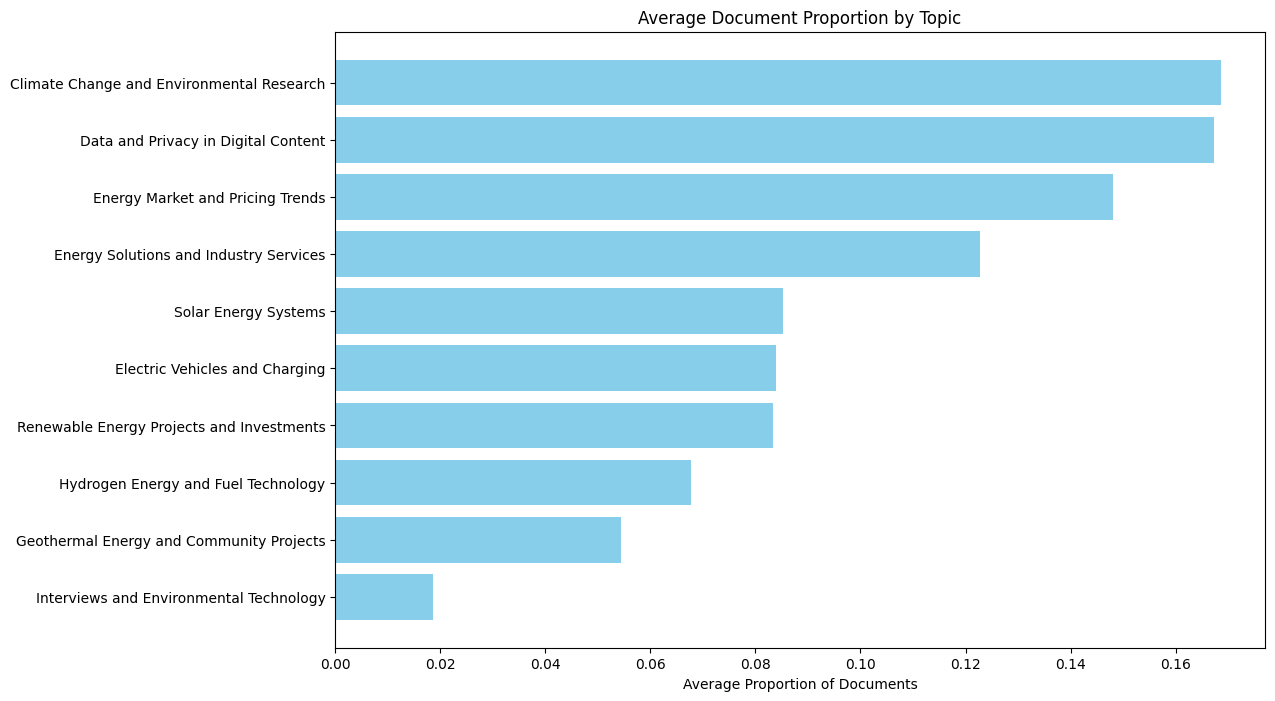

In [27]:
import matplotlib.pyplot as plt

# Calculate the average proportion for each renamed topic
topic_averages = doc_topic_df_renamed.mean()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    "Topic": topic_averages.index,  # Topic names
    "Average Proportion": topic_averages.values  # Corresponding average proportions
}).sort_values(by="Average Proportion", ascending=False)  # Sort for better visualization

# Plot the bar chart
plt.figure(figsize=(12, 8))
plt.barh(plot_data["Topic"], plot_data["Average Proportion"], color='skyblue')
plt.xlabel("Average Proportion of Documents")
plt.title("Average Document Proportion by Topic")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


### Most Prominent Topics according to Top2vec:

**Climate Change and Environmental Research**:
 has the highest average document proportion, indicating a significant focus on environmental and climate-related issues.

**Data and Privacy in Digital Content**:
 ranks second, highlighting the importance of data security and privacy in the energy sector.

**Energy Market and Pricing Trends**:
This is also prominent, reflecting interest in market dynamics and pricing.

---

#### Moderately Represented Topics Top2vec:

- Energy Solutions and Industry Services and Solar Energy Systems have moderate representation, indicating a consistent focus but less dominance than the top three topics.
- Electric Vehicles and Charging is similarly well-represented, suggesting ongoing discussions about sustainable transportation.
Least Represented Topics:

- Interviews and Environmental Technology has the lowest average document proportion, suggesting it is less emphasized in the dataset.
Geothermal Energy and Community Projects and Hydrogen Energy and Fuel
- Technology are also among the least prominent, indicating niche focus areas.
#### Summary:
The chart reflects the dataset's thematic priorities, with the most attention given to climate change, data privacy, and energy markets. Topics like interviews and niche technologies receive comparatively less focus. This insight helps prioritize discussions or analysis based on relevance.

## GENSIM-LDA

In [38]:
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Define the documents as the list of text from 'content_preprocessed' column
# documents = data['content_preprocessed'].tolist()
# Tokenize the preprocessed documents for LDA
processed_docs = [doc.split() for doc in documents]

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Print the topics with keywords
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# Visualize LDA topics
pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)

Topic 0: 0.028*"data" + 0.019*"website" + 0.014*"solar" + 0.012*"magazine" + 0.010*"module" + 0.010*"purpose" + 0.008*"setting" + 0.008*"cookie" + 0.008*"cooky" + 0.008*"storage"
Topic 1: 0.032*"energy" + 0.017*"system" + 0.015*"power" + 0.012*"solar" + 0.011*"solution" + 0.010*"technology" + 0.009*"product" + 0.009*"battery" + 0.007*"based" + 0.006*"xprt"
Topic 2: 0.032*"energy" + 0.023*"solar" + 0.016*"project" + 0.008*"power" + 0.008*"renewable" + 0.007*"capacity" + 0.006*"new" + 0.006*"year" + 0.006*"storage" + 0.005*"grid"
Topic 3: 0.012*"hydrogen" + 0.008*"emission" + 0.007*"research" + 0.007*"carbon" + 0.007*"technology" + 0.007*"use" + 0.006*"fuel" + 0.006*"gas" + 0.005*"azocleantech" + 0.005*"environmental"
Topic 4: 0.020*"geothermal" + 0.006*"year" + 0.006*"electric" + 0.006*"vehicle" + 0.005*"one" + 0.005*"also" + 0.005*"new" + 0.004*"company" + 0.004*"well" + 0.004*"time"


### Interpretation of the Graph:

This graph represents the **topic modeling visualization** for Topic 1 using **Latent Dirichlet Allocation (LDA)**. It consists of two main components:

#### 1. **Intertopic Distance Map (Left Plot)**:
   - **Red Circle (Topic 1)**: Represents the selected topic, which accounts for **33% of tokens** in the dataset.
   - **Blue Circles (Other Topics)**: Represent other topics, with their size indicating their prevalence. Larger circles represent more prevalent topics.
   - **Overlap**: Indicates shared terms or thematic similarities between topics. Topic 1 slightly overlaps with Topic 3, suggesting some shared terms or themes.
   - **Distance**: The farther apart the circles, the more distinct the topics.

#### 2. **Top-30 Most Relevant Terms (Right Bar Chart)**:
   - Shows the **top 30 words most relevant to Topic 1**.
   - **Red Bars**: Represent the overall term frequency across all topics.
   - **Blue Bars**: Represent the estimated term frequency specific to Topic 1.
   - **Key Terms for Topic 1**: Words like "energy," "solar," "project," "power," and "renewable" dominate, suggesting Topic 1 relates to renewable energy and energy projects.

---

### Summary:
- **Topic 1** is the largest topic according to LDA, covering 33% of the dataset, and focuses on renewable energy, solar projects, and related terms.
- Topics are moderately distinct, with some overlap between Topic 1 and Topic 3.
- The most relevant terms provide insights into the key themes and vocabulary of Topic 1.

## NMF

In [39]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Convert the documents to TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)

# Fit the NMF model..5 topics
num_topics = 5  # Choose an appropriate number of topics
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf)

# Extract topics
feature_names = tfidf_vectorizer.get_feature_names_out()
for index, topic in enumerate(nmf_model.components_):
    print(f"Topic {index + 1}: ", [feature_names[i] for i in topic.argsort()[-10:][::-1]])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1:  ['solar', 'energy', 'project', 'capacity', 'power', 'renewable', 'new', 'year', 'state', 'said']
Topic 2:  ['data', 'website', 'magazine', 'purpose', 'deleted', 'personal', 'cookie', 'party', 'protection', 'setting']
Topic 3:  ['azocleantech', 'plastic', 'spoke', 'interview', 'womens', 'planet', 'organization', 'day', 'international', 'research']
Topic 4:  ['recharge', 'group', 'medium', 'read', 'wind', 'nhst', 'data', 'offshore', 'responsible', 'secure']
Topic 5:  ['energy', 'based', 'power', 'xprt', 'battery', 'geothermal', 'solution', 'product', 'technology', 'heat']


In [40]:
# Fit the NMF model..  for 10 topics
num_topics = 10  # Choose an appropriate number of topics
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf)

# Extract topics
feature_names = tfidf_vectorizer.get_feature_names_out()
for index, topic in enumerate(nmf_model.components_):
    print(f"Topic {index + 1}: ", [feature_names[i] for i in topic.argsort()[-10:][::-1]])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1:  ['energy', 'project', 'renewable', 'solar', 'grid', 'power', 'storage', 'clean', 'wind', 'capacity']
Topic 2:  ['data', 'website', 'magazine', 'purpose', 'deleted', 'personal', 'cookie', 'party', 'protection', 'setting']
Topic 3:  ['azocleantech', 'plastic', 'spoke', 'womens', 'interview', 'planet', 'organization', 'day', 'international', 'research']
Topic 4:  ['recharge', 'group', 'medium', 'read', 'nhst', 'wind', 'data', 'responsible', 'secure', 'variety']
Topic 5:  ['energy', 'based', 'xprt', 'power', 'solution', 'product', 'heat', 'supplier', 'usa', 'line']
Topic 6:  ['geothermal', 'heat', 'drilling', 'heating', 'energy', 'resource', 'project', 'pump', 'development', 'source']
Topic 7:  ['tesla', 'cleantechnica', 'vehicle', 'electric', 'car', 'charging', 'sale', 'model', 'year', 'ev']
Topic 8:  ['battery', 'storage', 'lithium', 'power', 'energy', 'lithiumion', 'inverter', 'grid', 'charging', 'product']
Topic 9:  ['solar', 'module', 'panel', 'cell', 'manufacturing', 'insta

### Interpretation of Results:

The NMF model has extracted **10 topics**, each defined by its most relevant terms. Below is the interpretation of the topics along with the thematic focus derived from the key terms.

---

#### **Topic 1: Renewable Energy Projects**
- **Key Terms**: energy, project, renewable, solar, power, storage, clean, wind, capacity
- **Interpretation**: This topic focuses on renewable energy initiatives, including solar and wind power, storage solutions, and clean energy capacity development.

#### **Topic 2: Data Privacy and User Behavior**
- **Key Terms**: data, website, magazine, personal, cookie, party, protection, setting
- **Interpretation**: This topic revolves around data privacy, user behavior on websites, cookie policies, and personal data protection in digital contexts.

#### **Topic 3: Sustainability and Environmental Advocacy**
- **Key Terms**: azocleantech, plastic, spoke, interview, planet, organization, international, research
- **Interpretation**: Highlights sustainability efforts, environmental organizations, discussions on plastic waste reduction, and advocacy for a cleaner planet.

#### **Topic 4: Charging Infrastructure for Electric Vehicles**
- **Key Terms**: recharge, group, medium, read, data, responsible, secure, charging
- **Interpretation**: This topic focuses on the development and security of charging infrastructure for electric vehicles, emphasizing responsibility and reliability.

#### **Topic 5: Energy Industry Solutions**
- **Key Terms**: energy, based, xprt, power, solution, product, heat, supplier
- **Interpretation**: Reflects the energy industry's emphasis on solutions such as heat systems, power products, and the role of suppliers in energy distribution.

#### **Topic 6: Geothermal Energy and Heating Systems**
- **Key Terms**: geothermal, heat, drilling, heating, resource, project, pump, development
- **Interpretation**: Centers on geothermal energy technologies and heating systems, highlighting the use of pumps, drilling, and resource development for sustainable heating.

#### **Topic 7: Electric Vehicles and Market Trends**
- **Key Terms**: tesla, cleantechnica, vehicle, charging, sale, model, year, ev
- **Interpretation**: Focuses on the electric vehicle market, including brands like Tesla, EV sales, charging infrastructure, and technological advancements.

#### **Topic 8: Battery Storage and Grid Integration**
- **Key Terms**: battery, storage, lithium, power, inverter, grid, charging, product
- **Interpretation**: Explores advancements in battery storage technologies, lithium-ion solutions, and their integration into power grids.

#### **Topic 9: Solar Panel Installation and Photovoltaics**
- **Key Terms**: solar, module, panel, cell, installation, photovoltaic, power, rooftop
- **Interpretation**: Discusses solar panel installations, rooftop photovoltaics, and module technologies for generating solar power.

#### **Topic 10: Hydrogen Energy and Fuel Technologies**
- **Key Terms**: hydrogen, green, fuel, gas, production, cell, carbon, ammonia
- **Interpretation**: Focuses on hydrogen energy as a green alternative, covering fuel cells, gas production, and reducing carbon emissions.

---

### Summary:
These 10 topics reflect distinct themes within the dataset, covering:
1. Renewable energy projects (solar, wind, geothermal, hydrogen).
2. Sustainability efforts and environmental advocacy.
3. Technological advancements in electric vehicles, battery storage, and energy grids.
4. Privacy and user behavior in the energy and environmental sectors.

The topics provide a comprehensive overview of key areas of interest and technological developments.

---

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


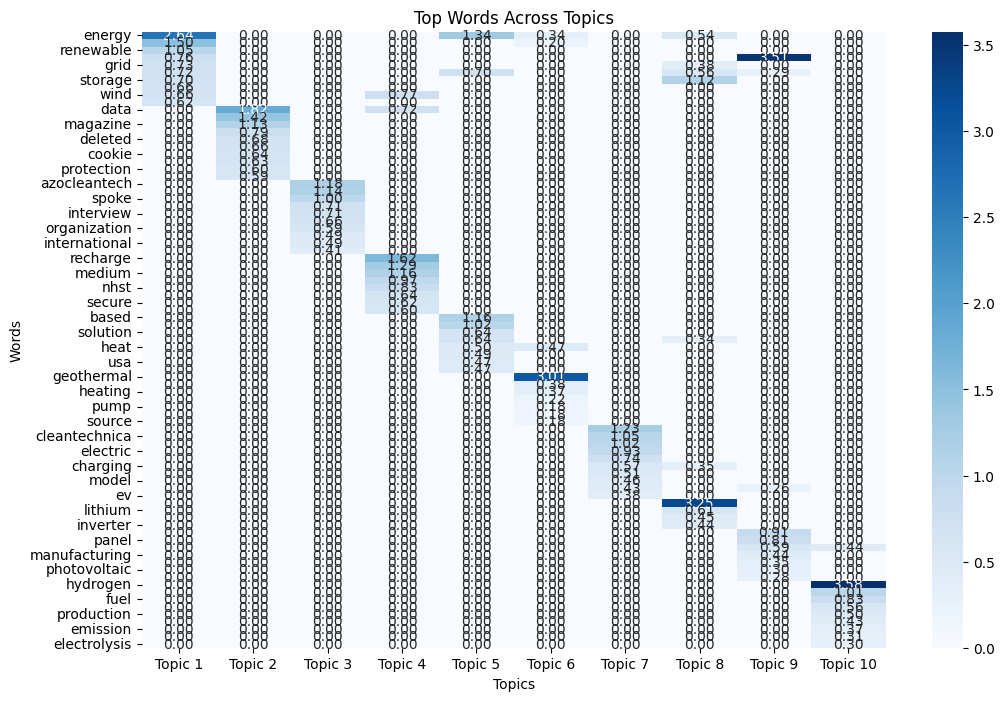

In [44]:
import seaborn as sns
import pandas as pd
# Parameters
num_top_words = 10  # Number of top words per topic
topics = nmf_model.components_  # NMF topics (word weights)
# Create a DataFrame of top words for each topic
heatmap_data = []
for topic_idx, topic in enumerate(topics):
    top_words_idx = topic.argsort()[-num_top_words:][::-1]  # Top word indices
    top_words = [feature_names[i] for i in top_words_idx]
    top_weights = topic[top_words_idx]
    heatmap_data.append(pd.Series(top_weights, index=top_words))

# Combine data for all topics
heatmap_df = pd.concat(heatmap_data, axis=1).fillna(0)
heatmap_df.columns = [f"Topic {i + 1}" for i in range(len(heatmap_data))]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap="Blues", annot=True, fmt=".2f")
plt.title("Top Words Across Topics")
plt.ylabel("Words")
plt.xlabel("Topics")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


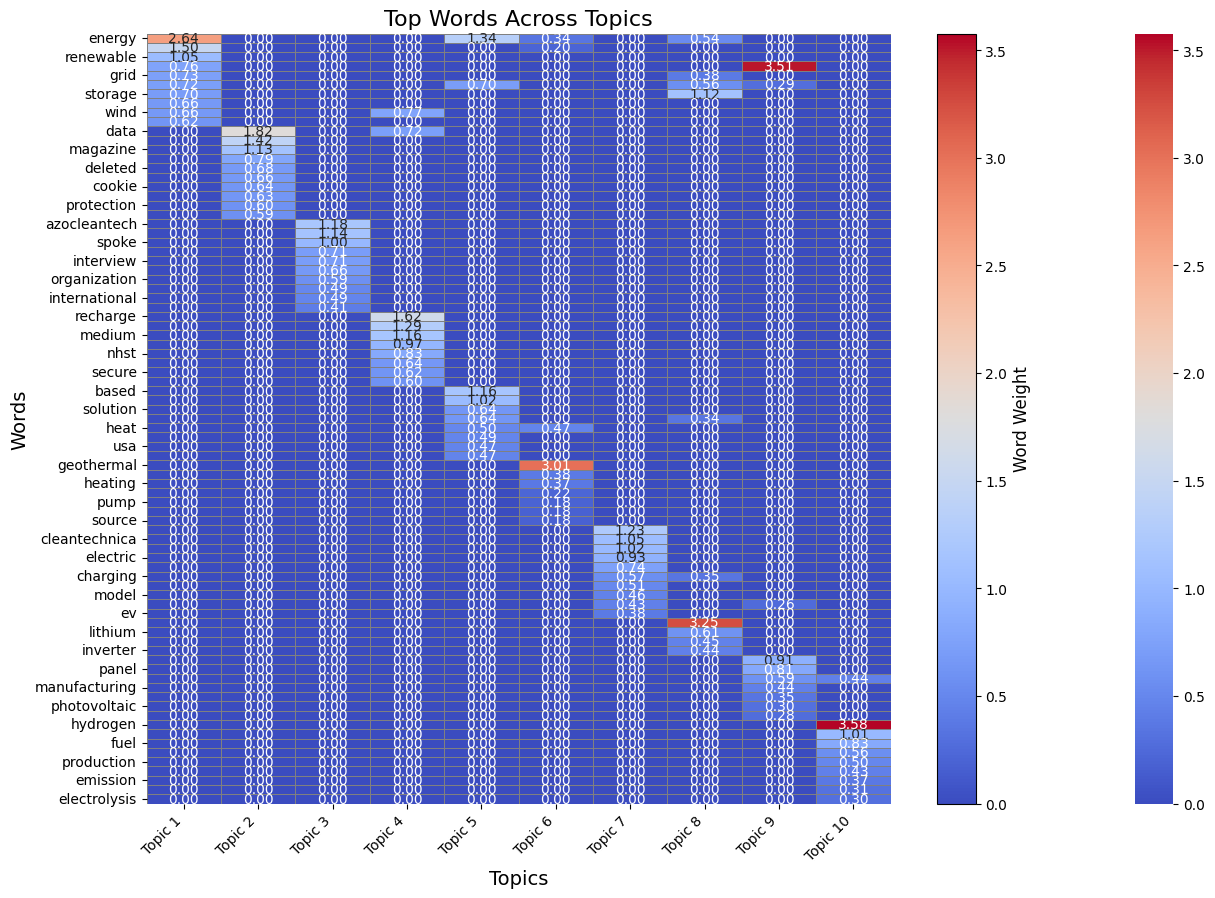

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Heatmap data preparation (your existing code)
heatmap_df.columns = [f"Topic {i + 1}" for i in range(len(heatmap_data))]

# Improved plot
plt.figure(figsize=(15, 10))
# Assign the heatmap to a variable
ax = sns.heatmap(heatmap_df, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, linecolor="gray")
plt.title("Top Words Across Topics", fontsize=16)
plt.xlabel("Topics", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(fontsize=10)
# Use the mappable returned by sns.heatmap instead of the ax
cbar = plt.colorbar(ax.get_children()[0])  # Get the first child, which is the heatmap
cbar.set_label("Word Weight", fontsize=12)
plt.show()

This heatmap represents the **top words across the identified topics** from your NMF model.

### **Key Points:**
1. **Rows (Words):**
   - These are the most important words (features) for the topics.
   - Words like *energy*, *renewable*, *grid*, and *wind* are frequently significant across different topics.

2. **Columns (Topics):**
   - These are the identified topics (Topic 1, Topic 2, etc.).
   - Each column represents the importance of the words (rows) for that topic.

3. **Color Intensity:**
   - The color represents the **weight (importance)** of a word for a topic:
     - Darker/red colors: Higher weight, meaning the word is more significant for that topic.
     - Lighter/blue colors: Lower weight, meaning the word is less relevant to that topic.

4. **Purpose:**
   - The heatmap highlights how much each word contributes to each topic.
   - For example, words like *geothermal* are more prominent in specific topics (e.g., Topic 10), while *energy* might have moderate relevance across multiple topics.

This visualization helps identify which words define each topic and their overlap across topics.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


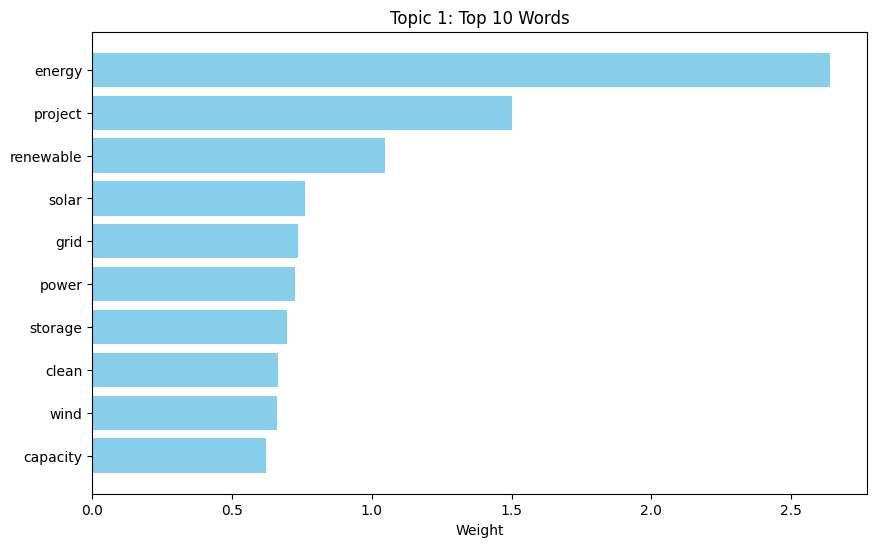

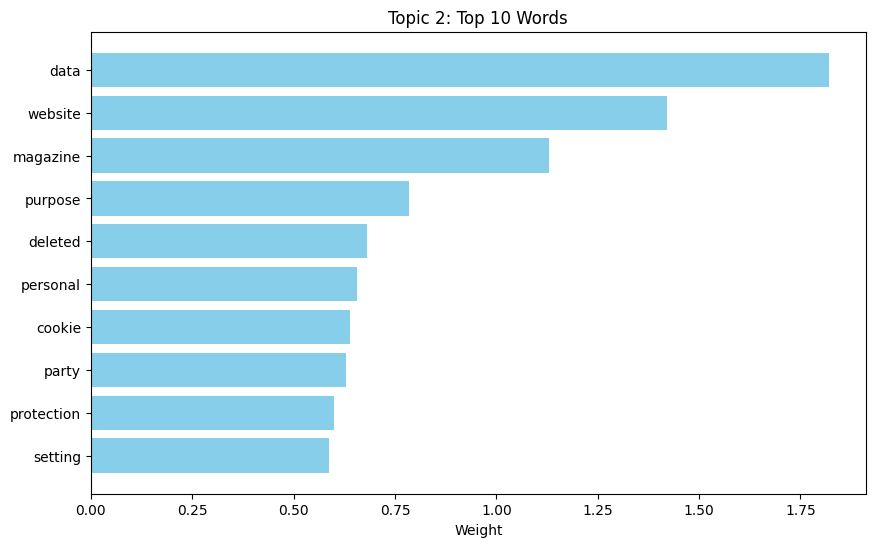

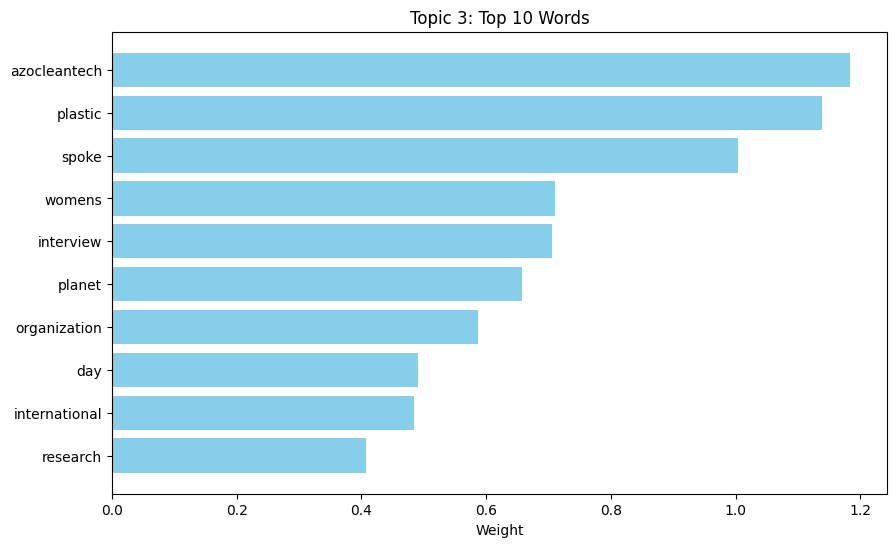

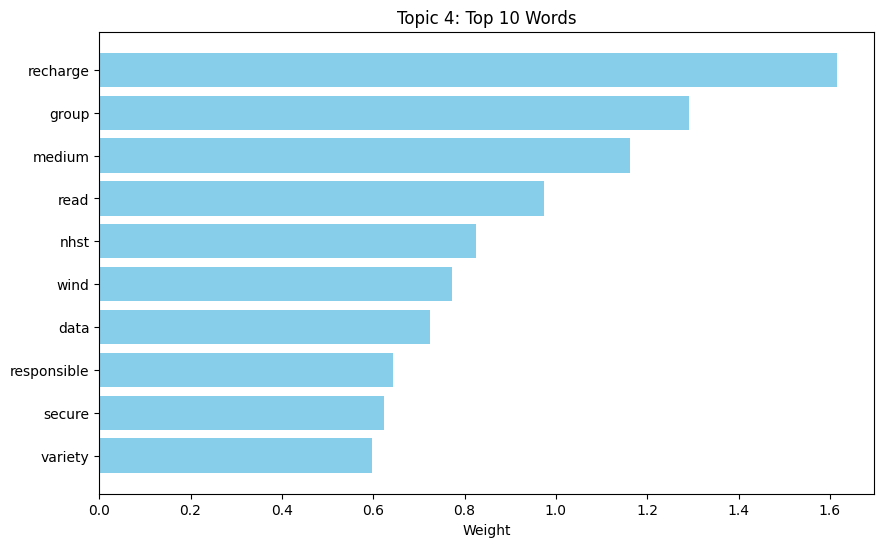

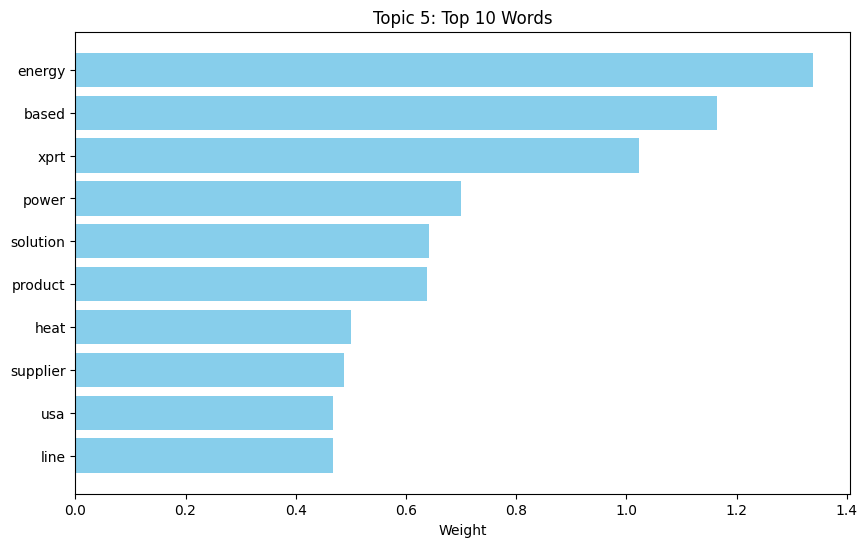

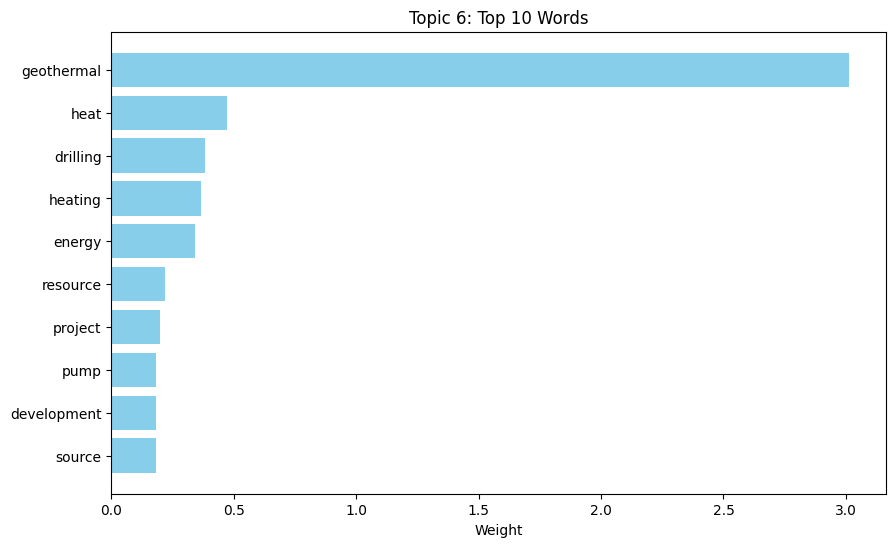

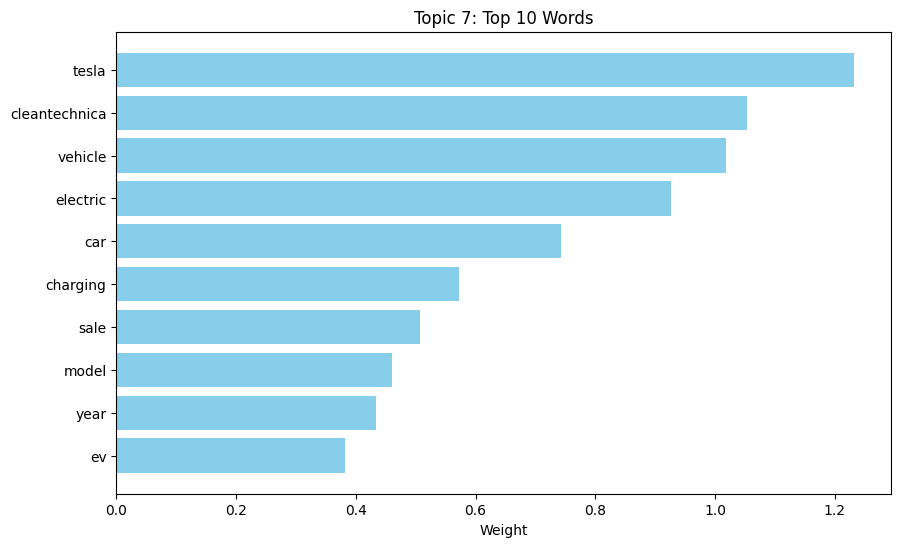

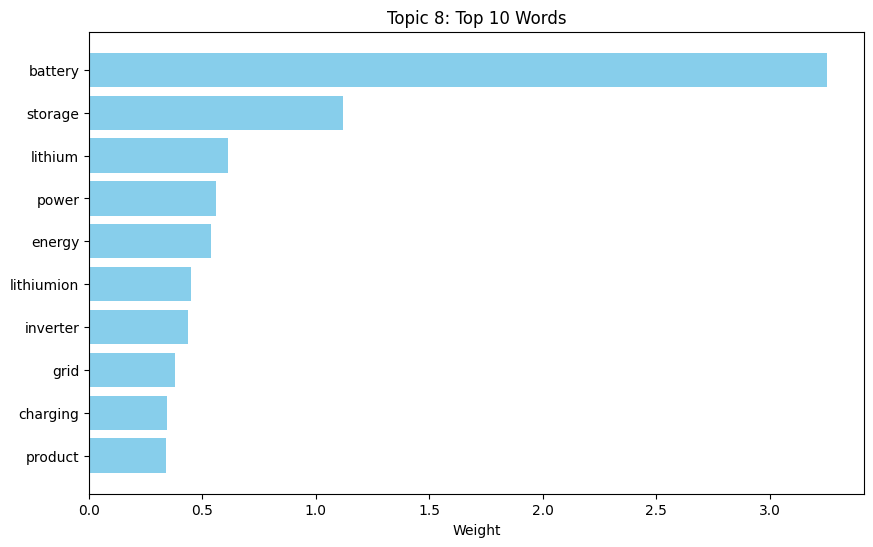

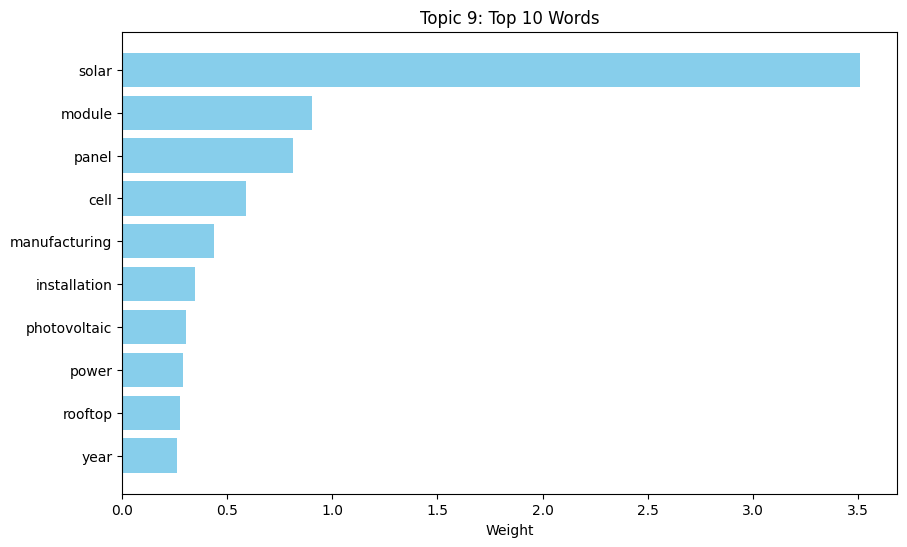

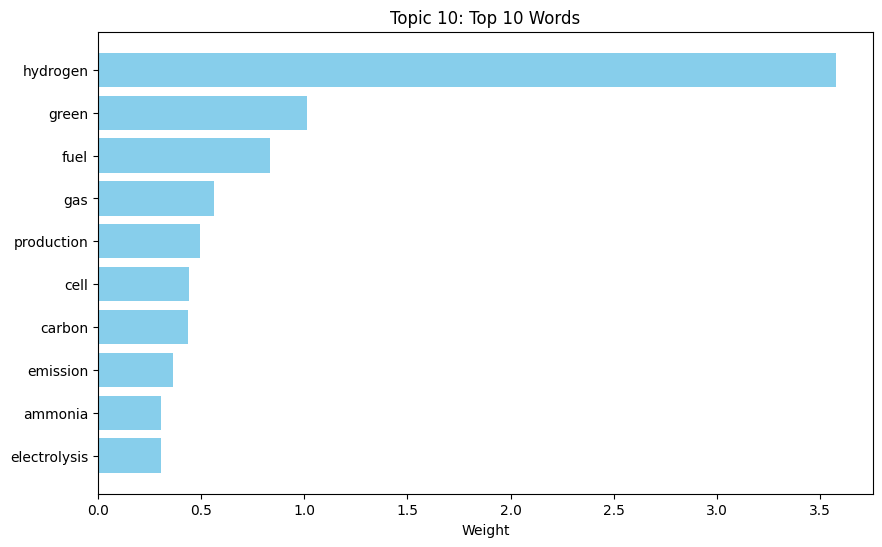

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
num_top_words = 10  # Number of top words per topic
topics = nmf_model.components_  # NMF topics (word weights)

# Plot top words for each topic
for topic_idx, topic in enumerate(topics):
    plt.figure(figsize=(10, 6))
    top_words_idx = topic.argsort()[-num_top_words:][::-1]  # Top word indices
    top_words = [feature_names[i] for i in top_words_idx]  # Extract top words
    top_weights = topic[top_words_idx]  # Corresponding weights

    # Create bar chart
    plt.barh(top_words, top_weights, color='skyblue')
    plt.xlabel("Weight")
    plt.title(f"Topic {topic_idx + 1}: Top {num_top_words} Words")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


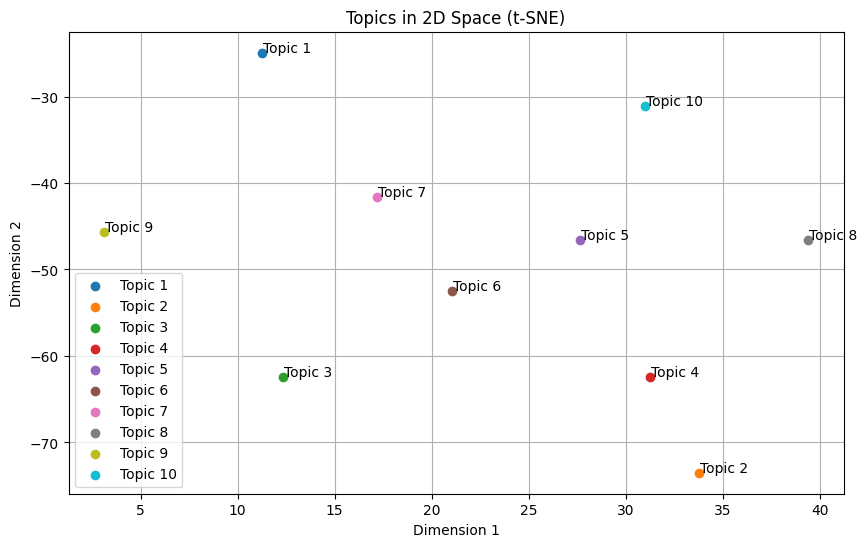

In [47]:
from sklearn.manifold import TSNE

# Reduce NMF topics to 2D using t-SNE
# Setting perplexity to 5, as it should be less than the number of samples (10 topics)
tsne_model = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_topic_vectors = tsne_model.fit_transform(nmf_model.components_)

# Plot the topics in 2D space
plt.figure(figsize=(10, 6))
for i, topic_vector in enumerate(tsne_topic_vectors):
    plt.scatter(topic_vector[0], topic_vector[1], label=f"Topic {i + 1}")
    plt.text(topic_vector[0] + 0.05, topic_vector[1] + 0.05, f"Topic {i + 1}")

plt.title("Topics in 2D Space (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

#### Interpretation of the Topics
Each labeled point (e.g., Topic 1, Topic 2, etc.) represents a topic identified by your NMF model:

#### Topic Proximity:
Topics that are near each other (e.g., Topic 6 and Topic 7) are more related or similar in terms of their word distributions.
Topics that are far apart (e.g., Topic 1 and Topic 9) are less related or have distinct word distributions.
#### Outliers:
Topics that are isolated from others (e.g., Topic 9, Topic 1) represent unique or very distinct topics in your dataset.

From this graph it seems that all topics seem well seperated and distinct from each other.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


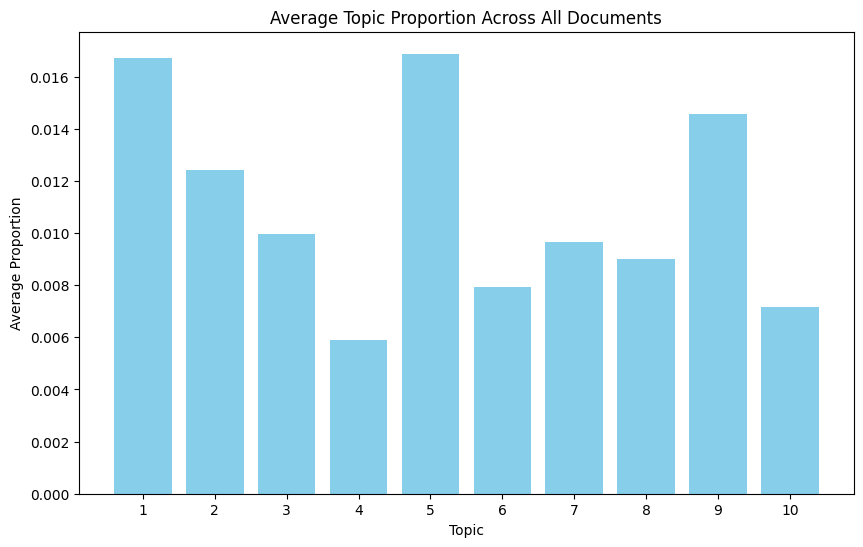

In [48]:
# Calculate the document-topic distribution
# to plot how dominant each topic is across all documents, use the document-topic matrix
doc_topic_dist = nmf_model.transform(tfidf)

# Calculate the average proportion of each topic across all documents
avg_topic_dist = np.mean(doc_topic_dist, axis=0)

# Plot the average topic distribution
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(avg_topic_dist) + 1), avg_topic_dist, color='skyblue')
plt.xlabel("Topic")
plt.ylabel("Average Proportion")
plt.title("Average Topic Proportion Across All Documents")
plt.xticks(range(1, len(avg_topic_dist) + 1))
plt.show()

doc_topic_dist = nmf_model.transform(tfidf)

# Calculate the average proportion of each topic across all documents
avg_topic_dist = np.mean(doc_topic_dist, axis=0)

# Plot the average topic distribution
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(avg_topic_dist) + 1), avg_topic_dist, color='skyblue')
plt.xlabel("Topic")
plt.ylabel("Average Proportion")
plt.title("Average Topic Proportion Across All Documents")
plt.xticks(range(1, len(avg_topic_dist) + 1))
plt.show()


In the document-topic matrix, each row corresponds to one document. Each row represents the contribution (or weight) of each topic to that specific document.

The **Non-Negative Matrix Factorization (NMF)** model and **Top2Vec** use fundamentally different approaches for topic modeling, which can lead to different results.

The differences:

---

### 1. **Mathematical and Algorithmic Approach**:
#### **NMF**:
- **Basis**: Matrix factorization.
- It decomposes the document-term matrix into two non-negative matrices: one representing topics (topic-word distribution) and the other representing documents (document-topic distribution).
- **Key Feature**: It assumes that topics are additive (a document is a mixture of topics) and relies heavily on the structure of the term frequency-inverse document frequency (TF-IDF) matrix.
- **Result**: Topics are usually distinct but can sometimes capture overlapping themes poorly, especially if words are shared between topics.

#### **Top2Vec**:
- **Basis**: Embedding-based approach using word and document vectors (e.g., word2vec, doc2vec, or transformer-based embeddings).
- **Key Feature**: Words and documents are embedded into a high-dimensional space, and clustering is applied to find topics in this vector space.
- **Result**: Topics are more context-aware and semantically rich because they rely on word embeddings to capture meaning, even if terms do not co-occur frequently.

---

### 2. **Handling of Semantic Meaning**:
- **NMF**: Focuses on co-occurrence of words in documents. It cannot capture relationships between words that don't frequently appear together but are semantically similar (e.g., "solar" and "photovoltaic").
- **Top2Vec**: Embedding-based methods capture semantic meaning and relationships, even for words that rarely co-occur, providing deeper insights into the dataset.

---

### 3. **Topic Interpretability**:
- **NMF**: Tends to produce more interpretable topics as it emphasizes distinct word groupings (e.g., "battery, storage, lithium"). However, it might oversimplify complex relationships.
- **Top2Vec**: May produce richer but less distinct topics due to overlapping word clusters, making interpretation more nuanced and requiring careful analysis.

---

### 4. **Preprocessing Sensitivity**:
- **NMF**: Relies on preprocessing (e.g., stop-word removal, stemming, and TF-IDF normalization). Results can vary significantly based on preprocessing quality.
- **Top2Vec**: Less sensitive to preprocessing as embeddings inherently capture semantic meaning, even for raw or unstructured text.

---

### 5. **Clustering Method**:
- **NMF**: Does not directly cluster documents but assumes topic distributions for documents. Requires additional steps (e.g., dominant topic assignment) for document-level grouping.
- **Top2Vec**: Directly clusters documents based on semantic similarity, making it better at associating similar documents with the same topic.

---

### Why Results Differ:
1. **NMF** tends to highlight **explicit co-occurrence patterns**, often producing distinct but narrower topics.
2. **Top2Vec** highlights **semantic similarity and contextual relationships**, which can result in broader, richer topics that overlap.

---

### Use Case Suitability:
- **NMF**: Better for datasets where word co-occurrence is strong and domain-specific terminology is consistent.
- **Top2Vec**: Better for diverse datasets with nuanced or complex relationships between terms.

Both methods are valid but suit different kinds of datasets and objectives. You might use NMF for interpretable results and Top2Vec for semantic richness or exploratory analysis. Let me know if you'd like further clarification!

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


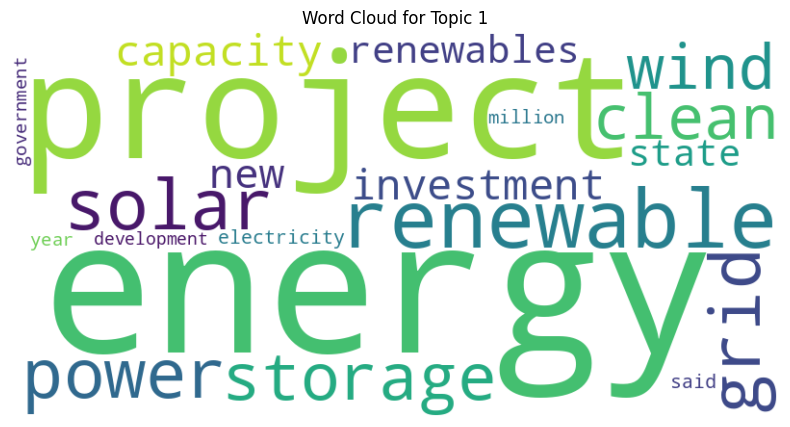

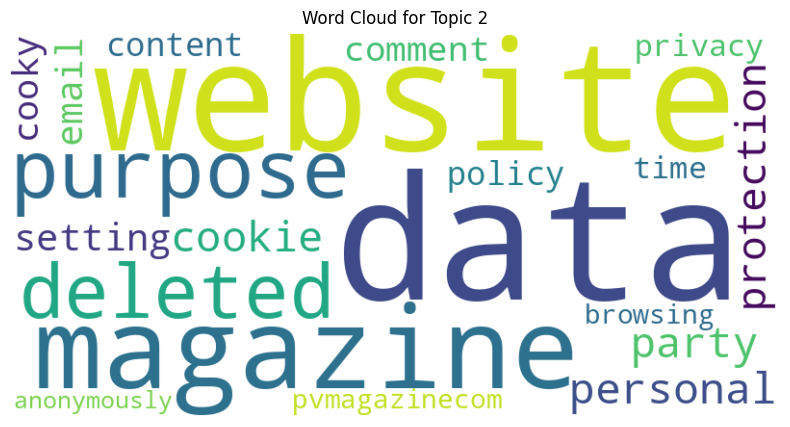

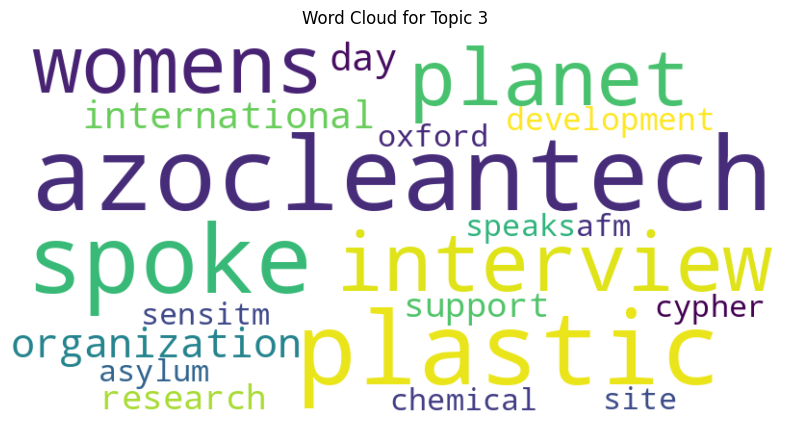

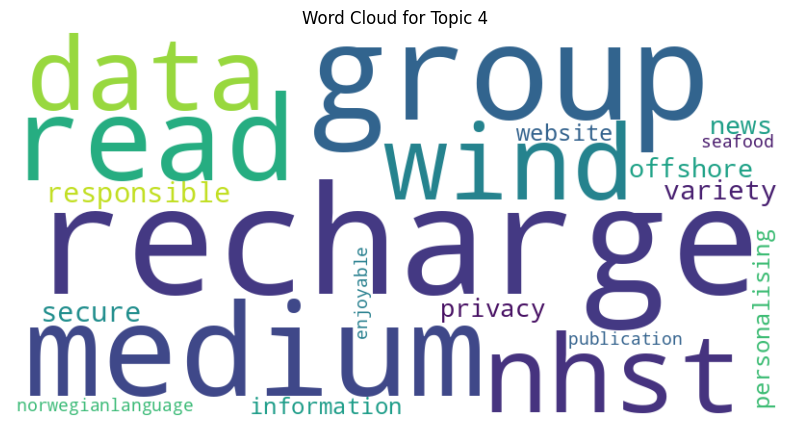

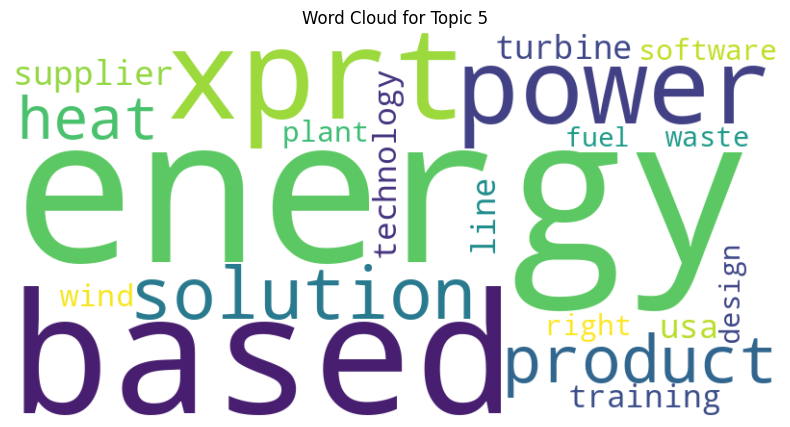

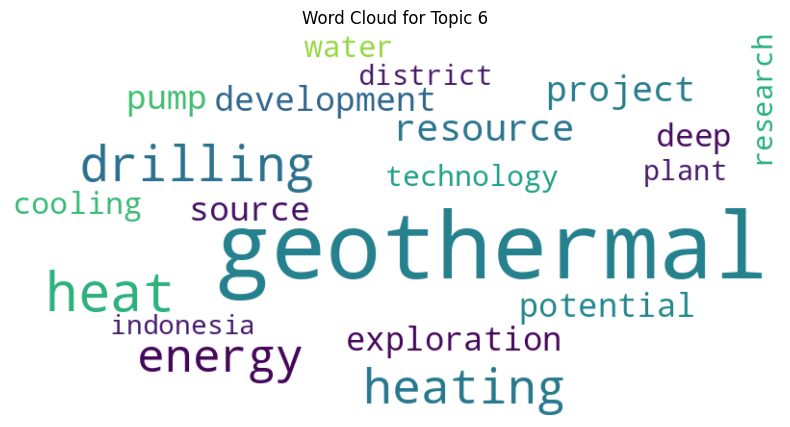

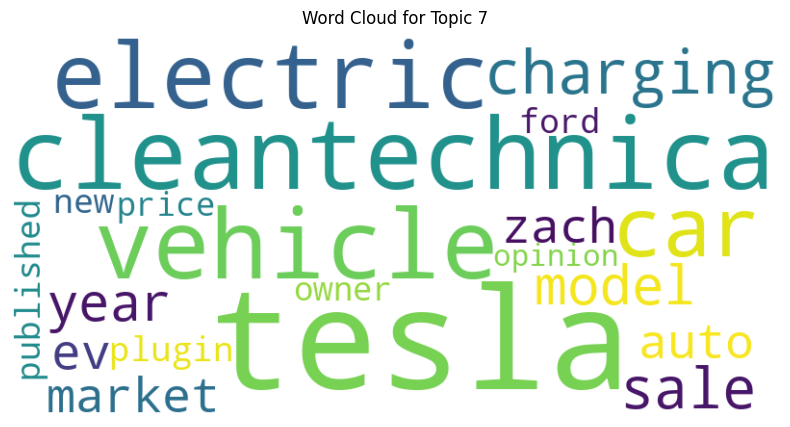

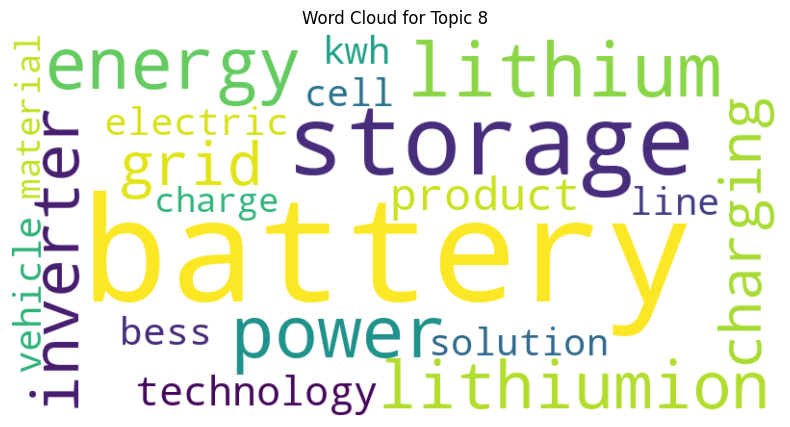

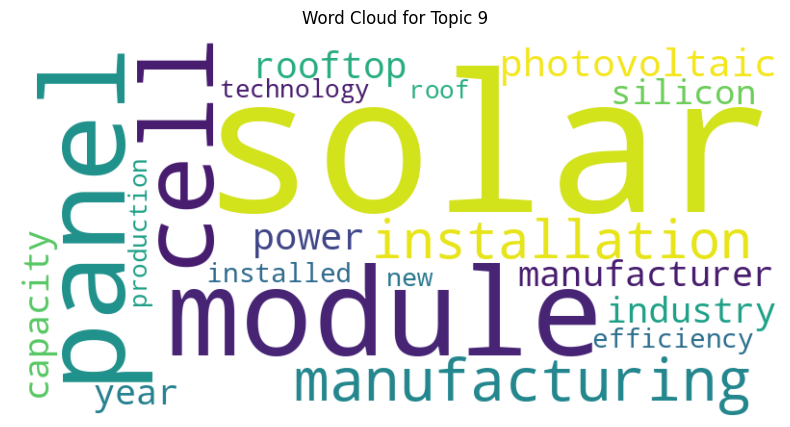

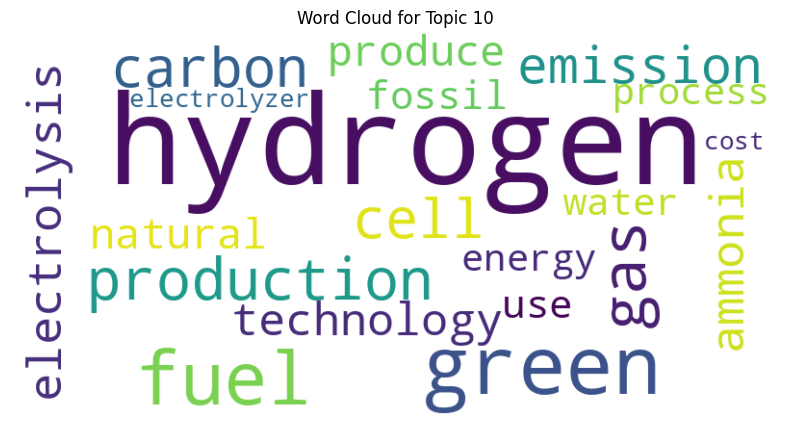

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create word clouds for each topic
def plot_word_clouds(nmf_model, feature_names, num_topics):
    for topic_idx, topic in enumerate(nmf_model.components_):
        # Generate a word cloud for the topic
        word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[-20:]}  # Top 20 words
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Topic {topic_idx + 1}")
        plt.show()

# Plot word clouds
plot_word_clouds(nmf_model, feature_names, num_topics)


####  This is the word cloud for the NMF model, where the most important words are shown.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


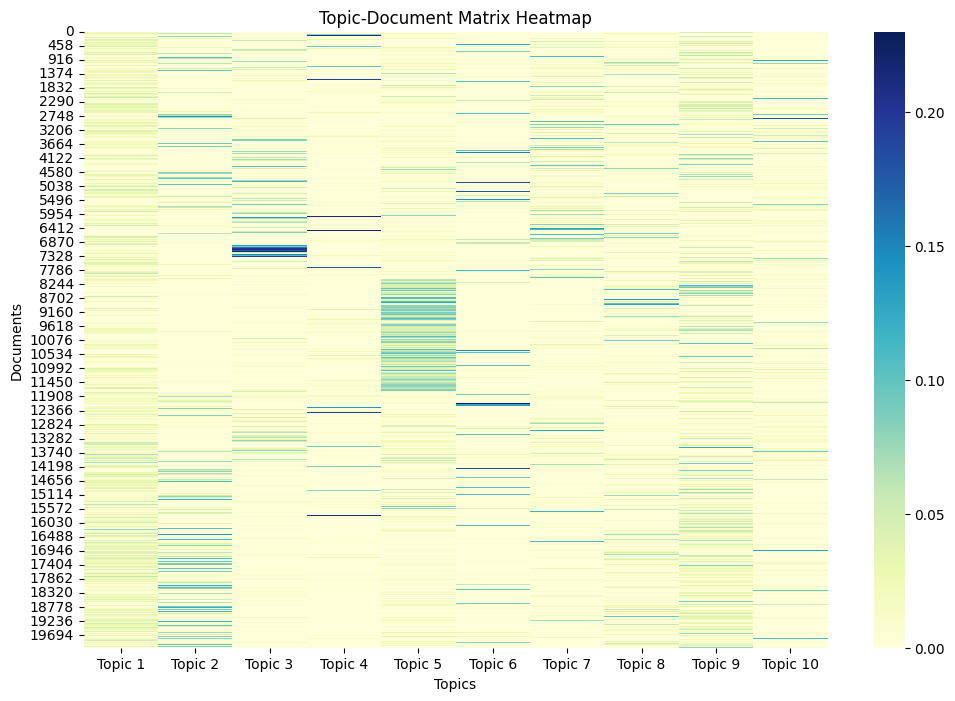

In [42]:
import seaborn as sns
import pandas as pd

# Generate topic-document matrix
topic_document_matrix = nmf_model.transform(tfidf)

# Convert to DataFrame for better readability
topic_document_df = pd.DataFrame(topic_document_matrix, columns=[f"Topic {i + 1}" for i in range(num_topics)])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(topic_document_df, cmap="YlGnBu", cbar=True)
plt.title("Topic-Document Matrix Heatmap")
plt.xlabel("Topics")
plt.ylabel("Documents")
plt.show()


### Interpretation of the Heatmap:

This is a **Topic-Document Matrix Heatmap**. Each row corresponds to a document, and each column represents a topic. The color intensity indicates the strength of the association (proportion or weight) between a document and a topic.

---

### Key Observations:
1. **Color Intensity**:
   - **Darker Colors** (closer to blue): Indicate a stronger association between a document and a topic.
   - **Lighter Colors** (closer to yellow): Indicate a weaker or no association between a document and a topic.

2. **Document-Topic Distribution**:
   - Many documents are lightly colored across most topics, showing they are weakly associated with those topics.
   - Some documents have strong associations with specific topics, indicated by darker rows in specific columns (e.g., strong associations visible for Topic 5, Topic 6, and Topic 8 in certain rows).

3. **Topic Representation**:
   - **Topic 5 and Topic 6** appear to have a relatively higher number of darker regions, suggesting these topics are strongly represented in certain documents.
   - Topics like **Topic 2 and Topic 7** have lighter regions overall, indicating they are less dominant or have weaker associations with documents.

4. **Document Clustering**:
   - Documents are not uniformly distributed across topics. Some clusters of documents are strongly tied to specific topics, while others are more distributed across multiple topics.

---

### Summary:
The heatmap provides an overview of the relationship between topics and documents:
- Certain topics, like **Topic 5** and **Topic 6**, dominate specific clusters of documents.
- Other topics, such as **Topic 2** or **Topic 7**, have more dispersed or weaker associations.
- This visual helps identify which topics are most prevalent and which documents are strongly linked to them, aiding in further analysis or document classification.